In [4]:
import numpy as np
import time
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.models import Model
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, MultiLabelBinarizer, label_binarize

from sklearn.model_selection import train_test_split
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
from lime.wrappers.scikit_image import SegmentationAlgorithm

In [7]:
os.listdir('/kaggle/input/')


['dataset', 'data.csv']

In [11]:
base_dir = '/kaggle/input/dataset/'
data_path = '/kaggle/input/data.csv'


data = pd.read_csv(data_path)
print(data.head())

   Unnamed: 0                                               path     label
0           0  Surprise/1bd930d6a1c717c11be33db74823f661cb53f...  Surprise
1           1       Surprise/cropped_emotions.100096~12fffff.png  Surprise
2           2  Surprise/0df0e470e33093f5b72a8197fa209d684032c...  Surprise
3           3       Surprise/cropped_emotions.260779~12fffff.png  Surprise
4           4       Surprise/cropped_emotions.263616~12fffff.png  Surprise


# Getting Unique Expressions

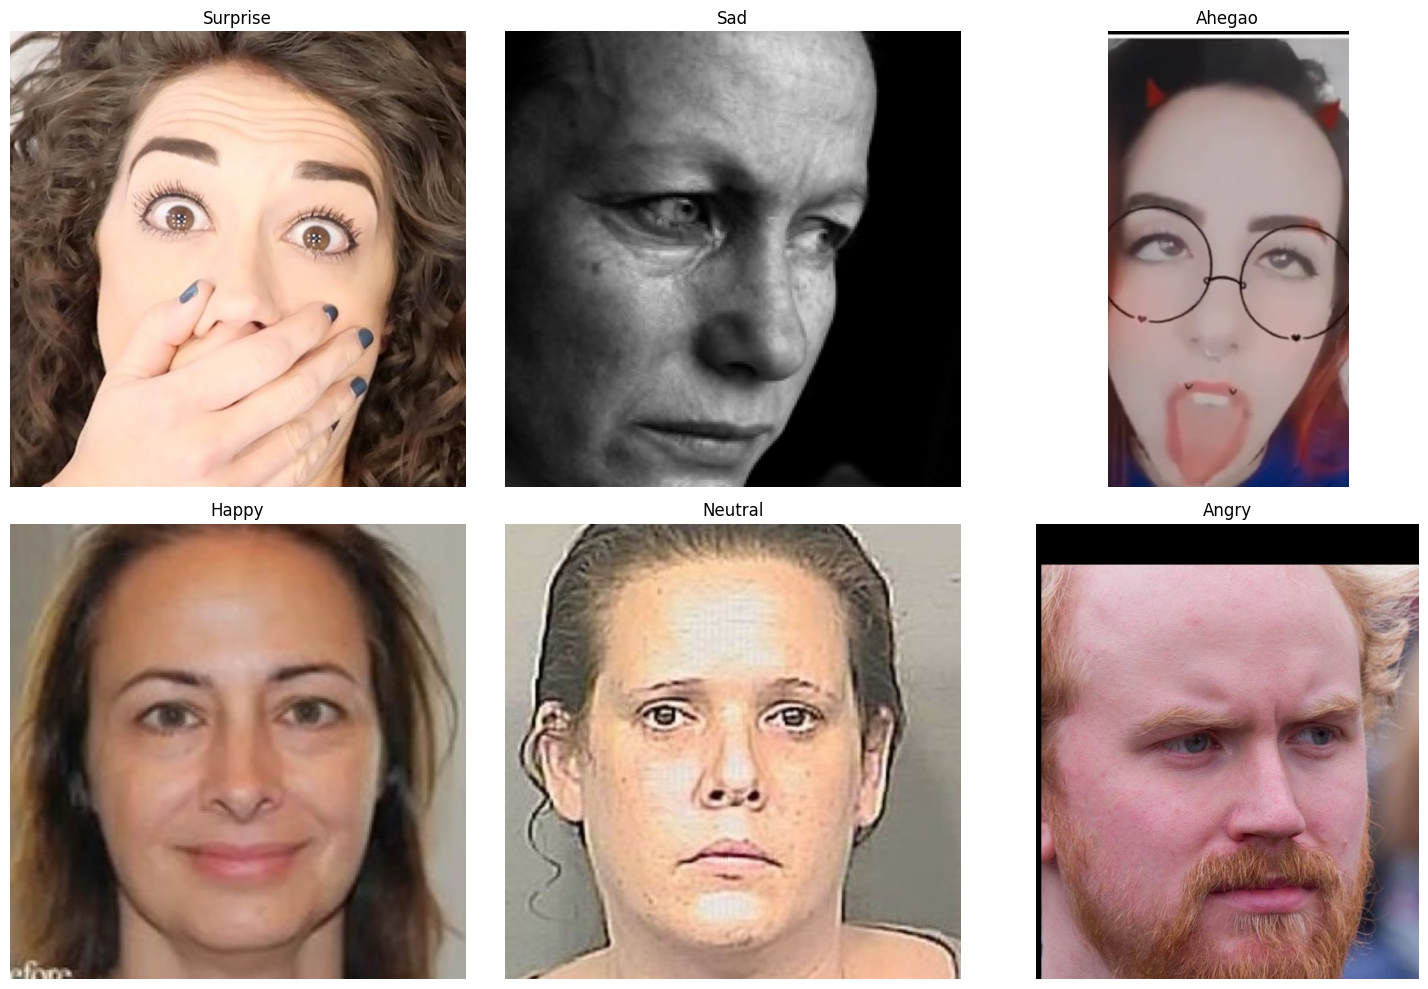

In [12]:

unique_expressions = data['label'].unique()


plt.figure(figsize=(15, 10))

for i, expression in enumerate(unique_expressions):
    
    sample_image_path = data[data['label'] == expression]['path'].values[0]
    full_image_path = os.path.join(base_dir, sample_image_path)
    
 
    image = cv2.imread(full_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.subplot(2, 3, i+1)
    plt.imshow(image)
    plt.title(expression)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [13]:
label_counts = data['label'].value_counts()
label_counts

label
Neutral     4027
Sad         3934
Happy       3740
Angry       1313
Surprise    1234
Ahegao      1205
Name: count, dtype: int64

In [14]:
num_samples = 1205
limited_data = data.groupby('label').apply(lambda x: x.sample(num_samples)).reset_index(drop=True)
limited_data

/tmp/ipykernel_34/4060996843.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  limited_data = data.groupby('label').apply(lambda x: x.sample(num_samples)).reset_index(drop=True)


,Unnamed: 0,path,label
0,5479,Ahegao/lol180~ahegao.png,Ahegao
1,5492,Ahegao/lol489~ahegao.png,Ahegao
2,5478,Ahegao/cropped_emotions.190427~ahegao.png,Ahegao
3,5537,Ahegao/cropped_emotions.39880~ahegao.png,Ahegao
4,6321,Ahegao/cropped_emotions.35525~ahegao.png,Ahegao
...,...,...,...
7225,133,Surprise/cropped_emotions.263579~12fffff.png,Surprise
7226,33,Surprise/cropped_emotions.100016~12fffff.png,Surprise
7227,1078,Surprise/0caf7252fd8751f1f4353c78fb21af64bee96...,Surprise
7228,648,Surprise/cropped_emotions.259992~12fffff.png,Surprise


# Splitting the data

In [15]:
train_val_data, test_data = train_test_split(limited_data, test_size=0.1, stratify=limited_data['label'], random_state=42)

In [17]:
def preprocess_image(image):
    processed_image = cv2.GaussianBlur(image, (3, 3), 0)
    return processed_image

def custom_preprocessing_function(image):
    image = np.array(image, dtype=np.uint8)
    image = preprocess_image(image)
    image = image.astype(np.float32)
    return image